In [1]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time
import random
import scipy.stats as stats
from scipy.sparse import *
from lsmc import *
from visualizingData import *
import pandas as pd
import os
import ast


In [2]:
# Load the data from the specified .npz file
file = np.load("..\\..\\data_manip\\provided_data\\QTOF.npz", allow_pickle=True)


# # Extract the necessary components from the file
print(file.files)

selected_B = file['selected_B'][()]
shape = file['shape'][()]
mz_values = file['mz'][()]



['selected_B', 'shape', 'mz']


In [3]:
selected_B.nnz/np.prod(selected_B.shape)

0.09466149611367851

In [4]:
# als je de sims of qtof om will zetten in een matrix die je miss wilt zien
dense_matrix_format = selected_B.toarray()
mask = np.where(dense_matrix_format==0, 0, 1)

In [5]:
# visualizeData(dense_matrix_format)
# visualizeData(mask)


In [6]:
DENSE, MASK = dense_matrix_format, mask

In [7]:
def dimensionChange(M,k):
    return M[:k,:k] 

def dataNMaskChange(M_dense_matrix, mask, k):
    M_dense_matrix = dimensionChange(M_dense_matrix,k)
    mask= dimensionChange(mask,k)
    return M_dense_matrix, mask


In [ ]:
DENSE, MASK = dataNMaskChange(M_dense_matrix=DENSE, mask=MASK, k=2000)

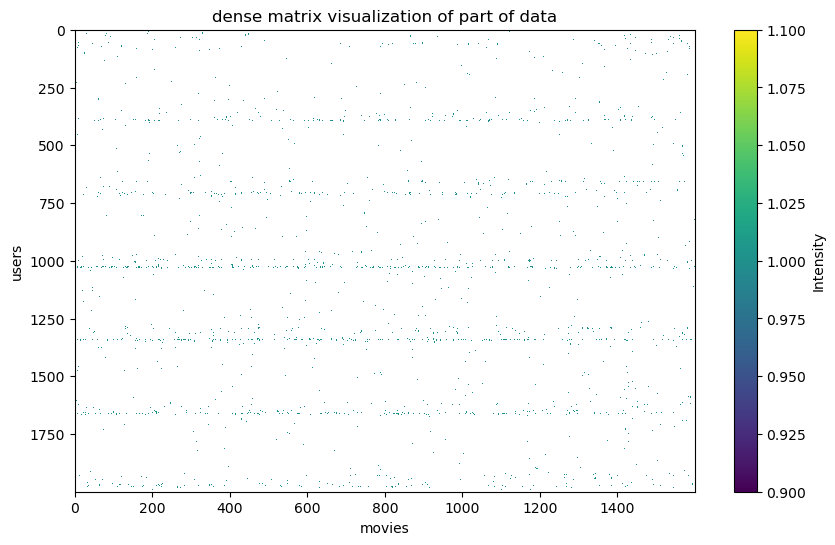

In [9]:
visualizeData(np.where(MASK==0,np.nan,1))

In [ ]:
# Matrix dimensions
m, n = DENSE.shape

# Initializing matrices and variables
R = DENSE  # Original dense matrix
P_init = np.random.rand(m, n)  # Initial guess for matrix P
u_init = np.zeros((m, n))  # Initial values for u
y_init = np.zeros((m, n))  # Initial values for y
s_init = 1  # Initial value for s

# Define ranges for hyperparametersgamma = .001
delta = 1e-2  # Tolerance level for optimization
num_iterations = 30  # Number of iterations for optimization
r_stop = min(m,n)//10
print(r_stop)
gamma=.001

# Generate rhos for each lambda
rho= .05*r_stop/np.linalg.norm(DENSE,'fro')

lamda=rho*.1  # Regularization parameter λ values

# LAMDA ALS FUNCTIE VAN RHO EN CURVEFITTEN VOOR WELKE WAARDE VAN X IK RHO*X= LAMDA MOET UITVOEREN

160


In [27]:
# Calculate epsilon based on matrix size and gamma
epsilon = m * n * gamma  # Error threshold as defined in the paper

# Print current parameter settings


# Run the optimization function with the current parameters
P_final, Z_final, u_final, y_final, s_final, errors, r_errors, rank = LMSC_optimize_rank_stop(
    rho, lamda, R, P_init, MASK, u_init, y_init, s_init, delta, epsilon, num_iterations, r_stop
)

Is lambda smaller then rho?: True
0: rank=10
10: rank=19
20: rank=19


In [21]:
lamda/rho

0.1

In [28]:
rank

19

In [29]:
r_errors

[(34.68103669532162, 0.45498843123693616, 35.13602512655852),
 (29.905199699572314, 0.5997032660524096, 30.504902965624726),
 (30.662993087831858, 0.5690446583422365, 31.23203774617407),
 (30.093686804087827, 0.5870012607525432, 30.680688064840346),
 (30.14521288219509, 0.5852653019518854, 30.730478184146953),
 (30.064726019909383, 0.5877367959727804, 30.65246281588215),
 (30.06441999940658, 0.5878013897806091, 30.65222138918716),
 (30.051706664945726, 0.5882345362035115, 30.639941201149206),
 (30.050155279541084, 0.588315251731134, 30.638470531272176),
 (30.04786922650362, 0.5884105245370332, 30.636279751040618),
 (30.047277412401762, 0.5884477431883159, 30.63572515559003),
 (30.04677276048195, 0.5884771494317508, 30.635249909913657),
 (30.046561748102363, 0.5884941531214293, 30.635055901223758),
 (30.04641010817727, 0.5885068692843911, 30.634916977461607),
 (30.04631994761523, 0.5885153223261981, 30.63483526994136),
 (30.04625550339305, 0.5885214722774739, 30.63477697567048),
 (30.04

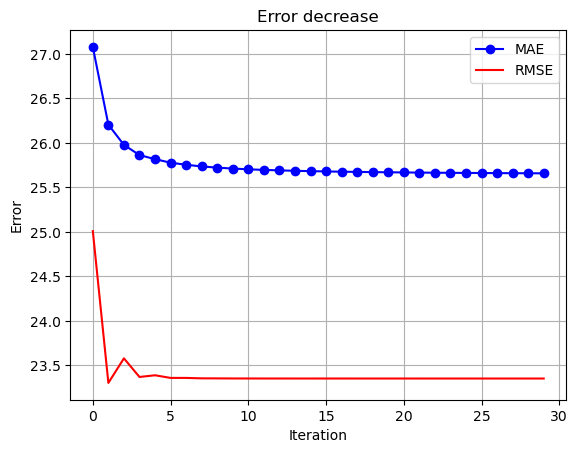

In [30]:
# relErrorPlot(errors=r_errors)
errorPlot(errors=errors)

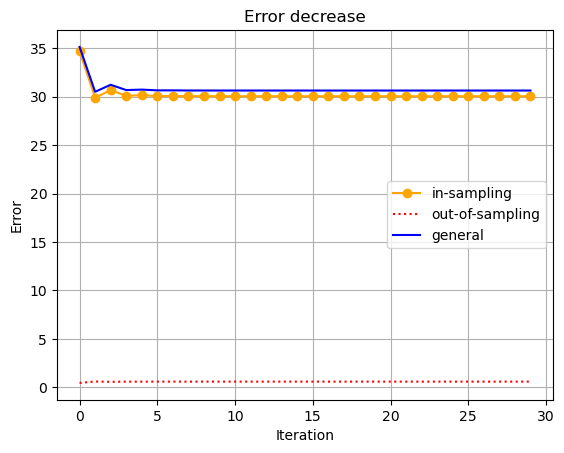

In [31]:
relErrorPlot(r_errors)

In [33]:
allErrors(ground_truth[:2000,:2000], Z_final, MASK)

NameError: name 'ground_truth' is not defined

In [34]:
allErrors(ground_truth[:2000,:2000], P_final, MASK)

NameError: name 'ground_truth' is not defined

In [35]:
csc_matrix(Z_final).nnz/np.prod(Z_final.shape)

0.1759137717121588

In [ ]:

def SVD_truncated(A, k):
    """
    Apply the thresholding operator to the singular values of X
    """
    U, S, V = np.linalg.svd(A, full_matrices=False)
    n= len(S)
    
    if k > n:
        k = n
    
    S= S[:k]
    U = U[:, :k]
    V = V[:k, :]
    return (U* S) @ V


In [67]:
100* np.linalg.norm(SVD_truncated(dense_matrix,20)-dense_matrix, 'fro')/np.linalg.norm(dense_matrix, 'fro')


35.45712492799889

In [97]:
100*np.linalg.norm((P_final-dense_matrix),'fro')/np.linalg.norm(dense_matrix,'fro')

ValueError: operands could not be broadcast together with shapes (400,2000) (400,1372421) 

In [65]:
100*np.linalg.norm((Z_final-dense_matrix),'fro')/np.linalg.norm(dense_matrix,'fro')

49.86943779810618